# Libraries & Hyperparameters

In [350]:
import torch
import torch.nn as nn
# import torch.nn.functional as F
import math
from transformers import AutoTokenizer
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
# from tokenizers import Tokenizer
# from tokenizers.models import BPE
# from tokenizers.trainers import BpeTrainer
# from tokenizers.pre_tokenizers import Whitespace

from collections import defaultdict

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

np.random.seed(42)

In [299]:
# Tokenization
VOCAB_SIZE = 500
# Data Preparation
SEQ_LEN = 50
# Model
EMBED_DIM = 128
HIDDEN_DIM = 128
NUM_LAYERS = 2

BATCH_SIZE = 64
grad_clip = 1
lr = 3e-5
betas = (0.9, 0.98)
wd = 0.05

# Data Preparation

## Load the Tiny Shakespeare text

In [280]:
corpus = []
skip_referrence = True
with open("input.txt", "r") as f:
    for line in f:
        line = line.strip('\n')
        if line == "":
            skip_referrence = True
            continue
        if skip_referrence:
            skip_referrence = False
            continue
        corpus.append(line)

## Tokenization

We tried BPE tokenizer directly as following code block, however the behavior of the model on this vocabulary was not good enough. Thus we turned to GPT2 Pre-tokenizer + Byte Pair Encoding.

In [281]:
# tokenizer = Tokenizer(BPE())
# tokenizer.pre_tokenizer = Whitespace()
# trainer = BpeTrainer(vocab_size = VOCAB_SIZE)
# tokenizer.train_from_iterator([corpus], trainer)
# stoi = dict(sorted(list(tokenizer.get_vocab().items()), key = lambda x: (len(x[0]), x[0])))
# itos = {i: s for s, i in sorted(list(stoi.items()), key = lambda x: x[1])}
# tokenized_corpus = []
# for line in corpus:
#     pieces = tokenizer.encode(line).ids
#     tokenized_corpus += pieces

Most of this part is borrowed from [HuggingFace](https://huggingface.co/learn/llm-course/en/chapter6/5), with slight modification to fit better in this small corpus.

In [282]:
word_freqs = defaultdict(int)
tokenizer = AutoTokenizer.from_pretrained("gpt2")
corpus_ = []
for text in corpus:
    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
    new_words = [word for word, offset in words_with_offsets]
    for word in new_words:
        if word.isupper():
            word = word.capitalize()
        word_freqs[word] += 1
    corpus_ += new_words

In [ ]:
alphabet = []
for word in word_freqs.keys():
    for letter in word:
        if letter not in alphabet:
            alphabet.append(letter)
alphabet.sort()
vocab = ["<|endoftext|>"] + alphabet.copy()
vocab = alphabet.copy()
splits = {word: [c for c in word] for word in word_freqs.keys()}

In [284]:
def compute_pair_freqs(splits):
    pair_freqs = defaultdict(int)
    for word, freq in word_freqs.items():
        split = splits[word]
        if len(split) == 1:
            continue
        for i in range(len(split) - 1):
            pair = (split[i], split[i + 1])
            pair_freqs[pair] += freq
    return pair_freqs
def merge_pair(a, b, splits):
    for word in word_freqs:
        split = splits[word]
        if len(split) == 1:
            continue
        i = 0
        while i < len(split) - 1:
            if split[i] == a and split[i + 1] == b:
                split = split[:i] + [a + b] + split[i + 2 :]
            else:
                i += 1
        splits[word] = split
    return splits

In [285]:
merges = {}
while len(vocab) < VOCAB_SIZE:
    pair_freqs = compute_pair_freqs(splits)
    best_pair = ""
    max_freq = None
    for pair, freq in pair_freqs.items():
        if max_freq is None or max_freq < freq:
            best_pair = pair
            max_freq = freq
    splits = merge_pair(*best_pair, splits)
    merges[best_pair] = best_pair[0] + best_pair[1]
    vocab.append(best_pair[0] + best_pair[1])
vocab = sorted(set(vocab), key = lambda x: (len(x), x))

We greedily tokenize the corpus.

In [286]:
stoi = {tok: i for i, tok in enumerate(vocab)}
itos = {i: tok for tok, i in stoi.items()}
MAX_WORD_LEN = len(vocab[-1])
def tokenize_word(word, vocab):
    tokens = []
    i = 0
    l = len(word)
    while i < l:
        for j in range(min(i + MAX_WORD_LEN, l), i, -1):
            piece = word[i:j]
            if piece in vocab:
                i = j
                tokens.append(stoi[piece])
                break
    return tokens

In [287]:
tokenized_corpus = []
for word in corpus_:
    pieces = tokenize_word(word, vocab)
    # print(pieces)
    # for p in pieces:
    #     print(itos[p], end = " ")
    # print()
    tokenized_corpus += pieces

In [288]:
for i in range(5):
    print(corpus_[i])
    tokens = tokenize_word(corpus_[i], vocab)
    print(tokens)
    for token in tokens:
        print(itos[token], end = " ")
    print()

Before
[70, 363]
Be fore 
Ġwe
[354]
Ġwe 
Ġproceed
[416, 92, 99]
Ġpro ce ed 
Ġany
[295, 61]
Ġan y 
Ġfurther
[187, 164, 376]
Ġf ur ther 


## Sequence formatting

In [289]:
inputs = []
targets = []
for i in range(len(tokenized_corpus) - SEQ_LEN):
    inputs.append(tokenized_corpus[i : i + SEQ_LEN])
    targets.append(tokenized_corpus[i + 1: i + 1 + SEQ_LEN])
inputs = torch.tensor(inputs, dtype=torch.long)
targets = torch.tensor(targets, dtype=torch.long)

print("inputs shape:", inputs.shape)
print("targets shape:", targets.shape)

inputs shape: torch.Size([423593, 50])
targets shape: torch.Size([423593, 50])


## Data split

To make sure there's no data leakage, we should split the dataset directly by the order of token sequences, i.e. the first 80% as train and the last 20% as validation.

In [290]:
SEQ_COUNT = int(len(inputs) * .8)
train_X = inputs[:SEQ_COUNT]
train_y = targets[:SEQ_COUNT]
val_X = inputs[SEQ_COUNT:]
val_y = targets[SEQ_COUNT:]
print(train_X.shape, train_y.shape)
print(val_X.shape, val_y.shape)

torch.Size([338874, 50]) torch.Size([338874, 50])
torch.Size([84719, 50]) torch.Size([84719, 50])


## Token embedding

RoPE is better for very long context windows. Now that we've chosen SEQ_LEN = 50, we'll use simple sinusoidal positional embeddings.

In [291]:
class PositionalEmbedding(nn.Module):
    def __init__(self, embed_dim, max_seq_len, base: float = 10000.0):
        super().__init__()
        pos_emd = torch.zeros(max_seq_len, embed_dim)
        position = torch.arange(0, max_seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2) * (-math.log(base) / embed_dim))
        pos_emd[:, 0::2] = torch.sin(position * div_term)
        pos_emd[:, 1::2] = torch.cos(position * div_term)
        # self.pos_emd = pos_emd
        self.register_buffer("pos_emd", pos_emd)
    
    def forward(self, x):
        # x in shape of [Batch, Tokens, Dims]
        # use broadcast
        B, T, D = x.size()
        return x + self.pos_emd[:T, :].unsqueeze(0)

# Implement a Tiny Transformer

In [292]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class RMSNorm(nn.Module):
    def __init__(self, embed_dim = EMBED_DIM, eps = 1e-8):
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(embed_dim))
        
    def forward(self, x):
        # x is of shape [Batch, Tokens, Dims]
        # normalize the embedding dimensions
        rms = x.pow(2).mean(dim = -1, keepdim = True).add(self.eps).sqrt()
        return x / rms * self.scale

class SelfAttention(nn.Module):
    def __init__(self, embed_dim = EMBED_DIM, mask = True):
        super().__init__()
        self.embed_dim = embed_dim
        self.scale = 1.0 / math.sqrt(embed_dim)
        self.q = nn.Linear(embed_dim, embed_dim)
        self.k = nn.Linear(embed_dim, embed_dim)
        self.v = nn.Linear(embed_dim, embed_dim)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.mask = mask

    def forward(self, x):
        B, T, D = x.shape
        q = self.q(x) # each in [B, T, Q] here Q = D
        k = self.k(x)
        v = self.v(x) # [B, T, V]
        # k.transpose(1, 2) in [B, K, T] where K = Q
        attn_scores = torch.bmm(q, k.transpose(1, 2)) * self.scale
        # out [B, T, T]

        # mask (i, j) if j > i for dimension T
        # out = sum att[i, j] v[j] over j in dimension T
        # hence only keeping lower triangle
        if self.mask:
            causal_mask = torch.tril(torch.ones(T, T, device=x.device)).bool()
            attn_scores = attn_scores.masked_fill(~causal_mask, float('-inf'))

        # softmax on dimension V
        attn_probs = torch.softmax(attn_scores, dim=-1)
        out = torch.bmm(attn_probs, v)  # [B, T, V]
        out = self.proj(out) # [B, T, D]
        return out, attn_probs

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim = EMBED_DIM, ffnn_hidden = HIDDEN_DIM):
        super().__init__()
        self.attn = SelfAttention(embed_dim)
        self.ffnn = nn.Sequential(
            nn.Linear(embed_dim, ffnn_hidden),
            nn.GELU(),
            nn.Linear(ffnn_hidden, embed_dim)
        )
        self.rms1 = RMSNorm(embed_dim)
        self.rms2 = RMSNorm(embed_dim)
    
    def forward(self, x):
        attn_out, attn_map = self.attn(self.rms1(x))
        x = x + attn_out
        ffnn_out = self.ffnn(self.rms2(x))
        x = x + ffnn_out
        return x, attn_map

class TinyTransformer(nn.Module):
    def __init__(self, vocab_size = VOCAB_SIZE, embed_dim = EMBED_DIM, 
                 num_layers = NUM_LAYERS, ffnn_hidden = HIDDEN_DIM, 
                 max_seq_len = SEQ_LEN):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, embed_dim)
        self.pos_enc = PositionalEmbedding(embed_dim, max_seq_len)
        self.layers = nn.ModuleList(
            [TransformerBlock(embed_dim, ffnn_hidden) for _ in range(num_layers)])
        self.rms_final = RMSNorm(embed_dim)
        self.lm_head = nn.Linear(embed_dim, vocab_size, bias=False)
    
    def forward(self, idx, need_attn=False):
        # idx in shape [B, T]
        x = self.token_emb(idx)
        x = self.pos_enc(x)
        attn_maps = []
        for layer in self.layers:
            x, attn_map = layer(x)
            if need_attn:
                attn_maps.append(attn_map)
        x = self.rms_final(x)
        logits = self.lm_head(x)
        return (logits, attn_maps) if need_attn else (logits, None)

# Model Training

In [293]:
def evaluate(model, dataloader):
    model.eval()
    total_loss = 0.0
    total_tokens = 0
    loss_fn = nn.CrossEntropyLoss(reduction = "sum") # for Perplexity
    
    with torch.no_grad():
        for xb, yb in dataloader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits, _ = model(xb)
            B, T, D = logits.shape
            loss = loss_fn(logits.view(B*T, D), yb.view(B*T))
            total_loss += loss.item()
            total_tokens += B * T
    avg_loss = total_loss / total_tokens
    ppl = math.exp(avg_loss)
    return avg_loss, ppl

In [300]:
train_dataset = TensorDataset(train_X, train_y)
val_dataset = TensorDataset(val_X, val_y)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = TinyTransformer().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = lr,
                              betas = betas, weight_decay = wd)

In [301]:
num_epochs = 20
loss_fn = nn.CrossEntropyLoss()
train_loss_ = []
val_loss_ = []
val_ppl_ = []
slices = []

NUM_BATCH = train_X.shape[0] // BATCH_SIZE + (
    1 if train_X.shape[0] % BATCH_SIZE == 0 else 0)
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (xb, yb) in enumerate(train_loader):
        xb = xb.to(device)
        yb = yb.to(device)
        
        logits, _ = model(xb)  # [B, T, D]
        B, T, D = logits.shape
        loss = loss_fn(logits.view(B*T, D), yb.view(B*T))

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        if i % 500 == 0:
            print(f"{i:4}" + "/" + str(NUM_BATCH), "batch loss =", loss.item())
        running_loss += loss.item()

    # evaluate
    val_loss, val_ppl = evaluate(model, val_loader)
    train_loss = running_loss / len(train_loader)
    train_loss_.append(train_loss)
    val_loss_.append(val_loss)
    val_ppl_.append(val_ppl_)
    slices.append(copy.deepcopy(model))
    print(f"Epoch {epoch+1}/{num_epochs} | train_loss {train_loss:.4f} | val_loss {val_loss:.4f} | val_ppl {val_ppl:.3f}")

   0/5294 batch loss = 6.3902130126953125
 500/5294 batch loss = 5.603116512298584
1000/5294 batch loss = 5.462903022766113
1500/5294 batch loss = 5.308985710144043
2000/5294 batch loss = 5.062462329864502
2500/5294 batch loss = 4.881281852722168
3000/5294 batch loss = 4.781650543212891
3500/5294 batch loss = 4.644182205200195
4000/5294 batch loss = 4.570744037628174
4500/5294 batch loss = 4.424808979034424
5000/5294 batch loss = 4.411384105682373
Epoch 1/20 | train_loss 4.9576 | val_loss 4.4839 | val_ppl 88.578
   0/5294 batch loss = 4.367015838623047
 500/5294 batch loss = 4.289495468139648
1000/5294 batch loss = 4.345645904541016
1500/5294 batch loss = 4.278390884399414
2000/5294 batch loss = 4.210529327392578
2500/5294 batch loss = 4.117604732513428
3000/5294 batch loss = 4.096757411956787
3500/5294 batch loss = 4.110508441925049
4000/5294 batch loss = 4.044566631317139
4500/5294 batch loss = 4.034152984619141
5000/5294 batch loss = 4.0079522132873535
Epoch 2/20 | train_loss 4.1616

In [ ]:
# total parameters
i = 0
for p in model.parameters():
    i += math.exp(sum(math.log(s) for s in p.shape))
print(int(round(i)))

326784


# Visualization & Interpretation

The best PPL on the validation set is 44.704 (epoch=19) and as training stops the PPL is 44.828.

## Training and Validation Loss Curves over Epochs

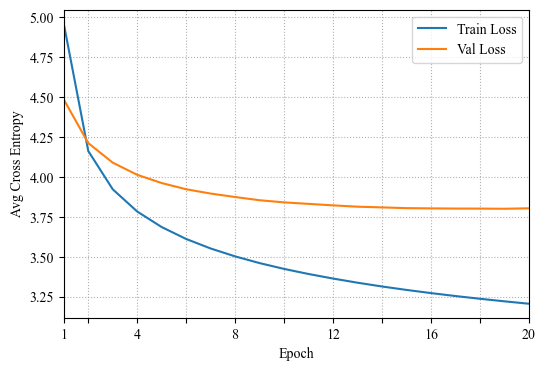

In [334]:
X = np.linspace(1, num_epochs, num_epochs)
plt.figure(figsize = (6, 4))
plt.plot(X, train_loss_, label = "Train Loss")
plt.plot(X, val_loss_, label = "Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Avg Cross Entropy")
plt.xticks([1] + [2 * i for i in range(1, 11)], 
           labels = [1] + [" " if i % 4 != 0 else i for i in range(2, 21, 2)])
plt.xlim(1, 20)
plt.legend()
plt.grid(True, 'major', linestyle = ':')
plt.show()

## Attention Heatmaps

In [459]:
def tokenize(text, vocab):
    tokens = []
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
    new_words = [word for word, offset in words_with_offsets]
    for word in new_words:
        if word.isupper():
            word = word.capitalize()
        tokens += tokenize_word(word, vocab)
    return tokens
def encode(tokens, transformed_space = False, replaced = ' '):
    if transformed_space:
        return [stoi[t] if t[0] != replaced else stoi['Ġ' + t[1:]] for t in tokens]
    return [stoi[t] for t in tokens]
def decode(token_ids, show_space = False, replace = ' '):
    tokens = [itos[int(t)] for t in token_ids]
    if show_space:
        for i in range(len(tokens)):
            if tokens[i][0] == 'Ġ':
                tokens[i] = replace + tokens[i][1:]
    return tokens


In [414]:
tokenize('Hello world!', vocab)

[71, 131, 51, 430, 128, 0]

Here the space is replaced with a underscore.

In [525]:
def plot_attention(model, vocab, text, idx = 0, max_seq_len=SEQ_LEN, figsize=(8, 6),
                   layers = None):
    model.eval()
    tokens = tokenize(text, vocab)
    tokens = tokens[:max_seq_len]
    x = torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)

    with torch.no_grad():
        logits, attn_maps = model(x, need_attn=True)
    
    i = torch.argmax(logits[0, idx, :]).item()
    prob = torch.softmax(logits[0, idx, :], dim = 0)[i].item()
    next_token = itos[i]
    if next_token[0] == 'Ġ':
        next_token = '_' + next_token[1:]
    
    token_strings = decode(tokens, show_space = True, replace = '_')
    T = len(tokens)
    
    for layer_i, attn in enumerate(attn_maps):
        assert idx <= T
        if layers and layer_i not in layers:
            break
        attn = attn[idx].cpu()  # take batch index 0

        if attn.dim() == 3:
            attn = attn.squeeze(0)

        plt.figure(figsize=figsize)
        sns.heatmap(attn[:T, :T], 
                    xticklabels=token_strings, 
                    yticklabels=token_strings, 
                    cmap="grey",
                    square=True)
        plt.title(f"Layer {layer_i+1} Self-Attention, next token = \"{next_token}\", " +
                  r"P$_{max}$" + f" = {prob:.2f}")
        plt.xlabel("Key Positions")
        plt.ylabel("Query Positions")
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
        

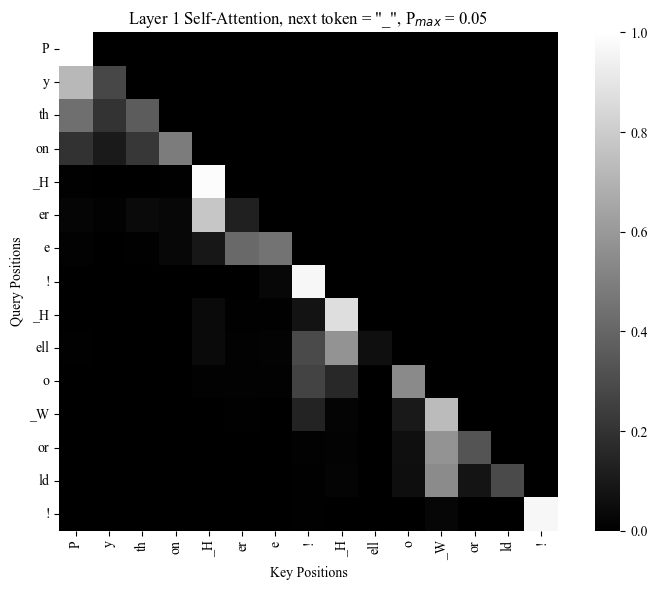

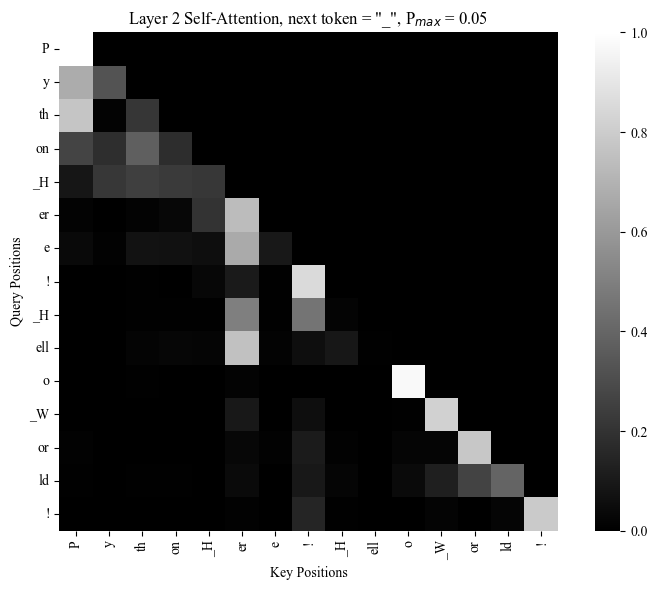

In [526]:
plot_attention(slices[-2], vocab, "Python Here! Hello World!", idx = -1)

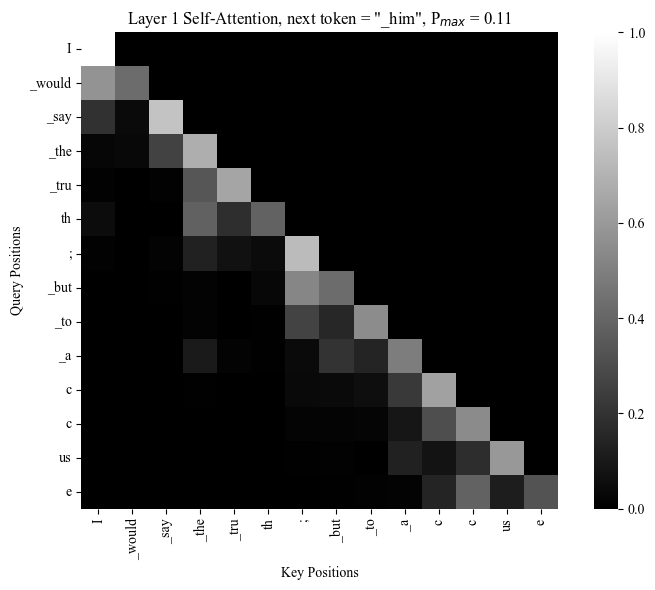

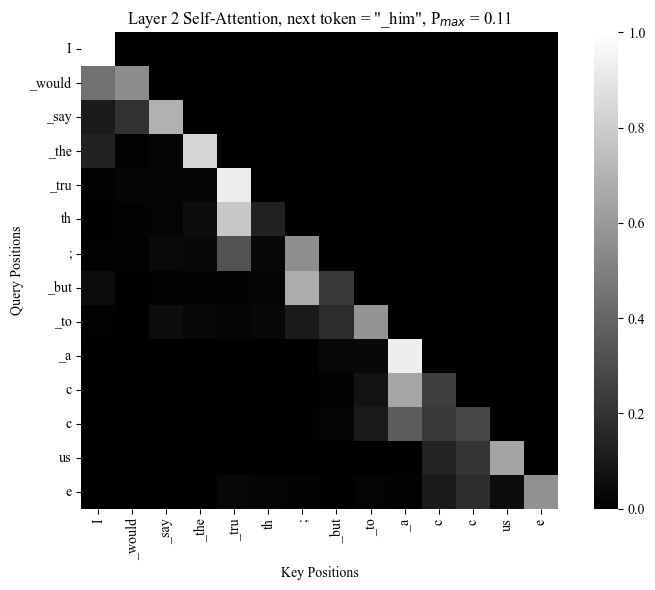

In [527]:
plot_attention(slices[-2], vocab, "I would say the truth; but to accuse", idx = -1)

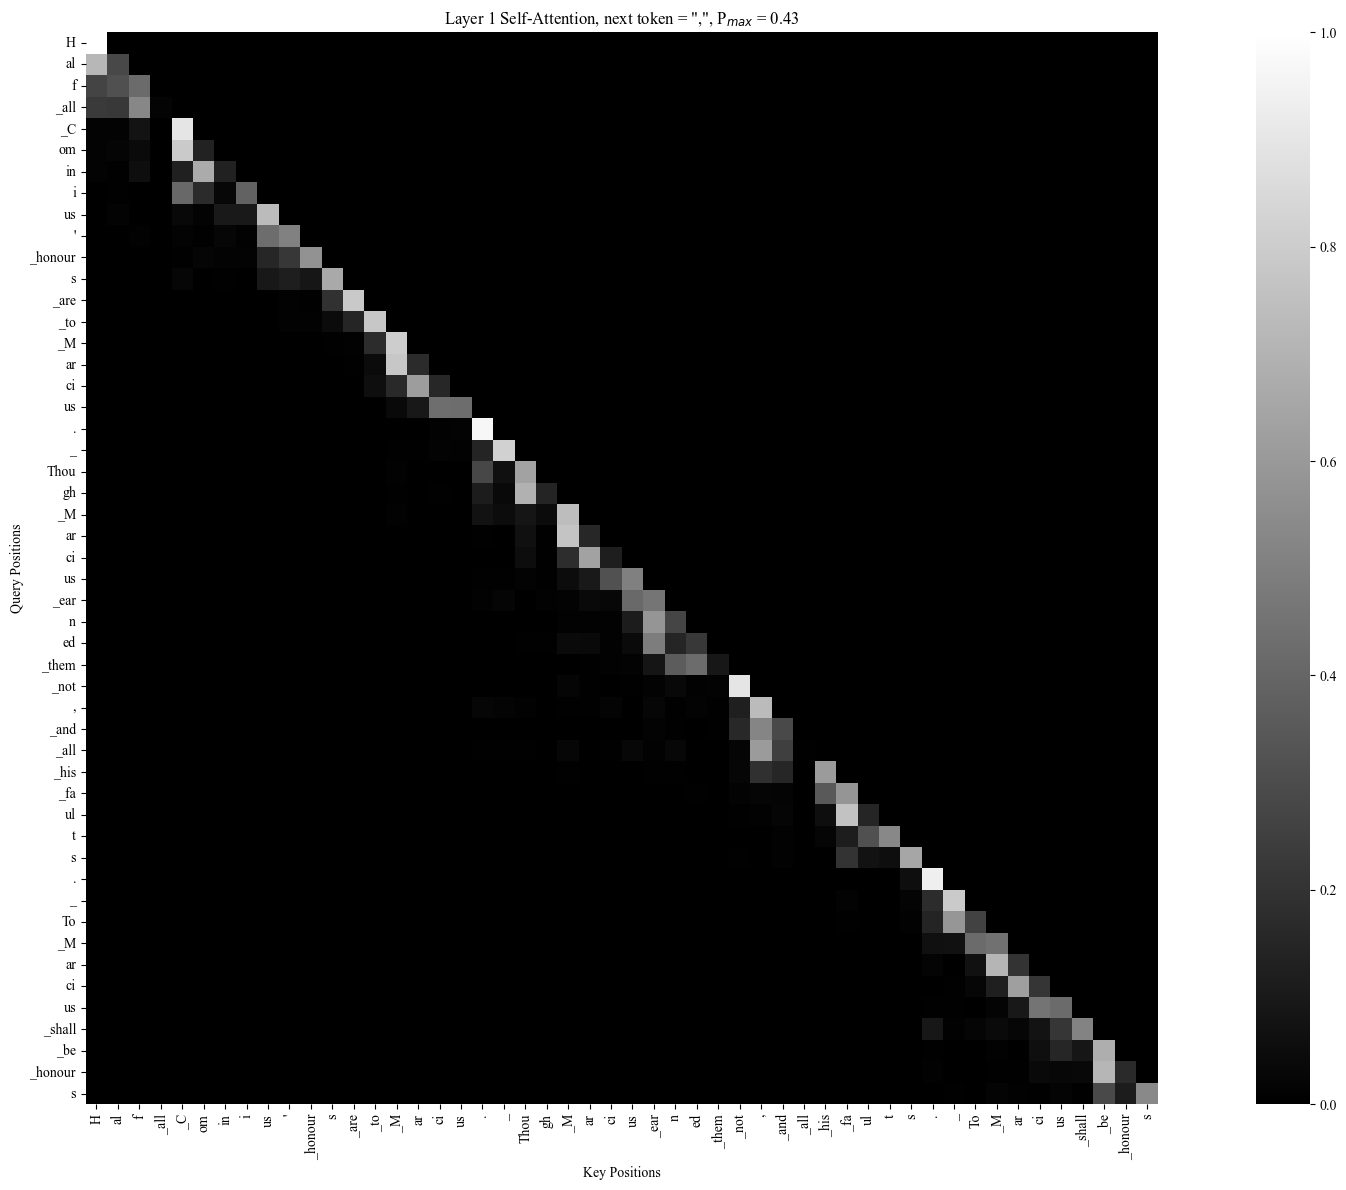

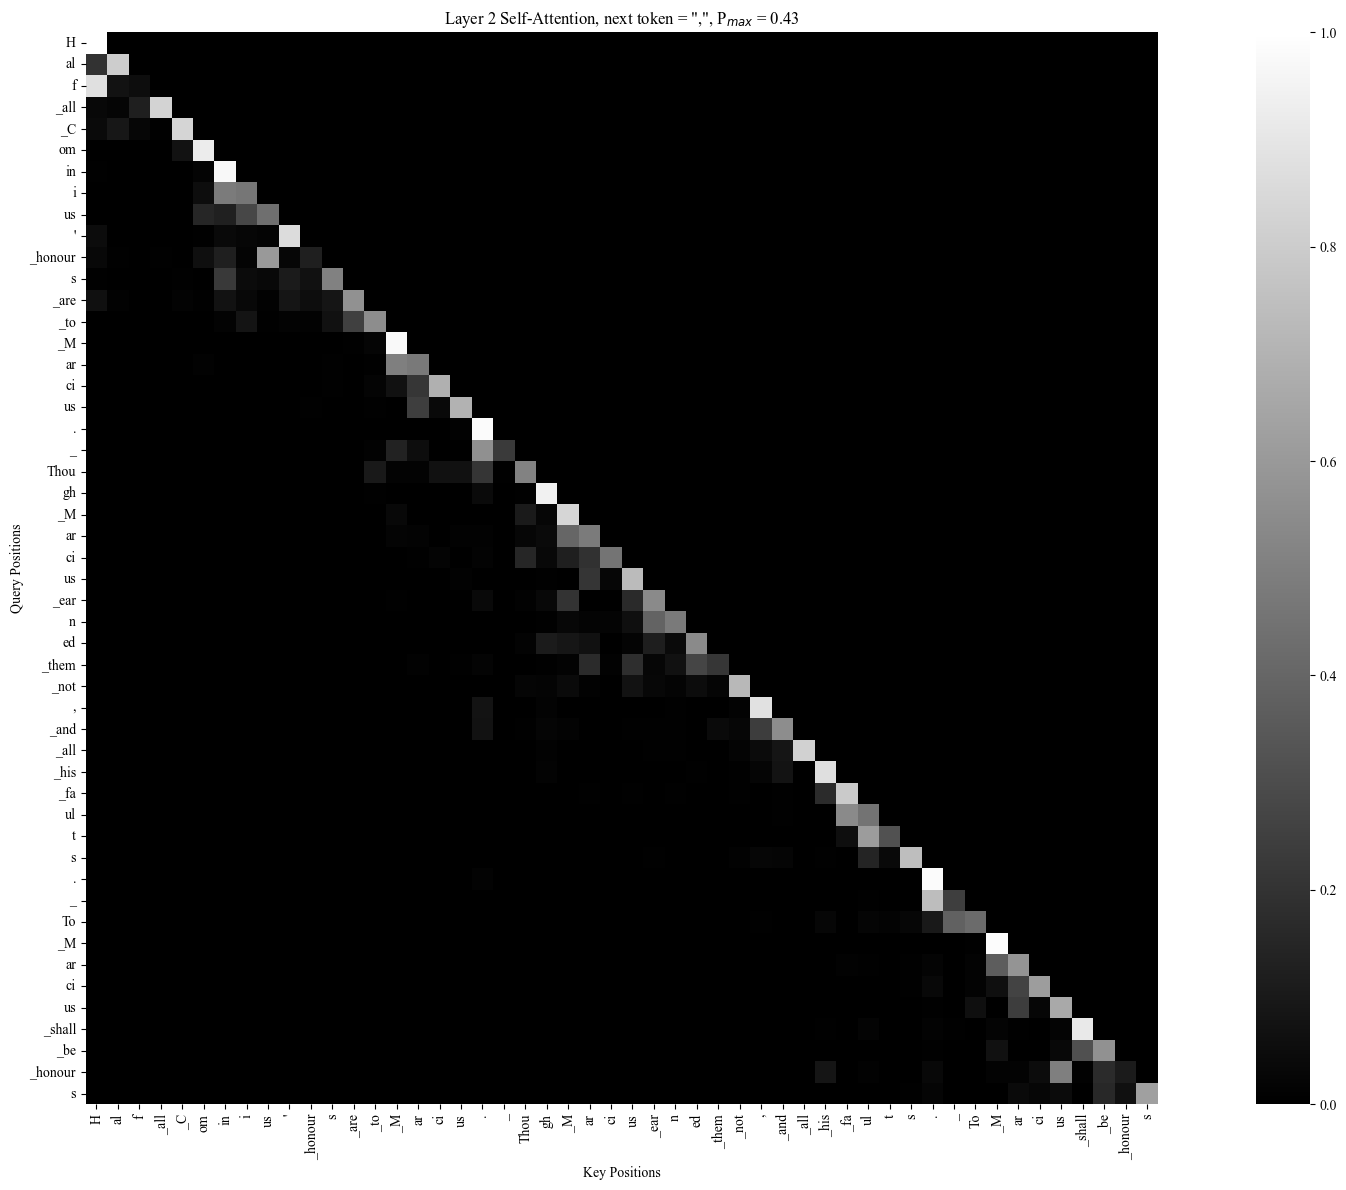

In [528]:
plot_attention(slices[-2], vocab, 
               "Half all Cominius' honours are to Marcius. Though Marcius earned them not, and all his faults. To Marcius shall be honours", 
               -1, figsize = (20, 12))

## Sample Generation

In [486]:
def generate(model, vocab, text, epoch = 1, max_seq_len = SEQ_LEN, loop_inf = False):
    model.eval()
    tokens = tokenize(text, vocab)
    tokens = tokens[:max_seq_len]
    if len(tokens) >= max_seq_len and not loop_inf:
        return
    probs = []
    while epoch > 0:
        if len(tokens) > max_seq_len and not loop_inf:
            break
        if len(tokens) > max_seq_len and loop_inf:
            x = x = torch.tensor(tokens[-SEQ_LEN:], dtype=torch.long).unsqueeze(0).to(device)
        else:
            x = torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)
        with torch.no_grad():
            logits, attn_maps = model(x, need_attn=True)

            i = torch.argmax(logits[0, -1, :]).item()
            prob = torch.softmax(logits[0, -1, :], dim = 0)[i].item()
            next_token = itos[i]
        probs.append((next_token, prob))
        tokens.append(i)
        epoch -= 1

    token_strings = decode(tokens, show_space = True, replace = ' ')
    return token_strings, probs

In [513]:
token_strings, probs = generate(slices[-2], vocab,
                                "Hello world! This is Python! ", epoch = 18)
print(*token_strings, sep = "", end = "")

Hello world! This is Python! I am appear to the crown,And I am advance

In [514]:
token_strings, probs = generate(slices[-2], vocab,
    "Against him first: he's a very dog to the commonalty. ", epoch = 18)
print(*token_strings, sep = "", end = "")

Against him first: he's a very dog to the commonalty. I have a king, I'll not beggar,And, as 

# Discussion & Reflection

*What patterns do you observe in the attention maps?*

The attention maps typically show that most semantically holistic combinations of tokens makes the model concentrate more on, generally reflecting the local dependency of natural language.

In early stages, the model remains underfitting and attention maps could be noisy and more uniform (shown below), but later the diagonal bands show up and structured spikes, triangles appear.

Interestingly, the vertical spikes and mutual attention show frequently on pairs or single punctuation, which shows the model gradually grasp the structure of the language through the punctuations.

*Which hyperparameters (learning rate, context length, model size) had the greatest impact on stability?*

I think the answer is Learning rate.

I trained this model under many learning rates and when it's too high, e.g. > 3e-3, the model learns nothing and the validation loss increases steadily. If it's too low or with a higher weight decay coefficient in AdamW, the model learns nothing (probably extremely slow) and got stuck. You have to maintain it or reduce it carefully in a feasible interval.

Context length has lighter influence on the stability if it is in the reasonable range.
If context length is too short, which is unreasonable, the data leakage could easily take place and the model will exhibit very good performance on validation set, though meaningless. Longer context makes the model understands better, but not always greatly helpful.

Model size: since we are only asked to implement 2 Transformer blocks, the parameters related to the model size which we can fiddle with are hidden state dimension (in FFN) and the embedding dimension. These had little impact on stability, again, in the reasonable range. For example, I tried hidden_dim = 16, 32, 512 and all results (val loss) are almost the same.

*How does attention evolve as the model trains over epochs?*

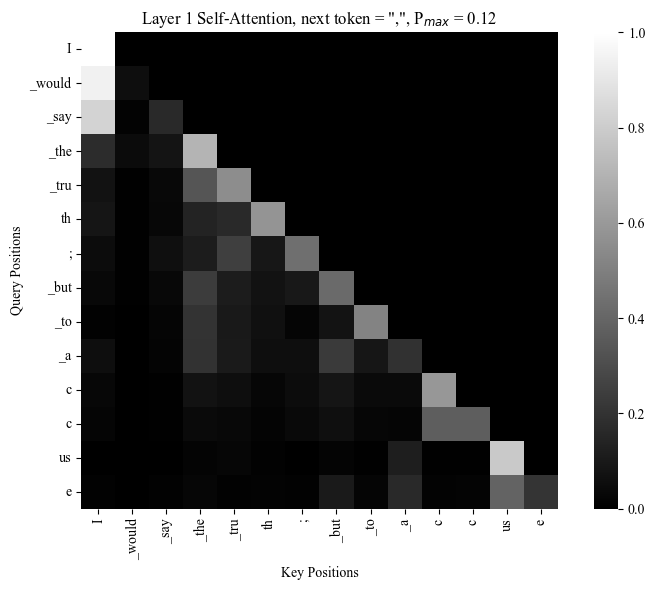

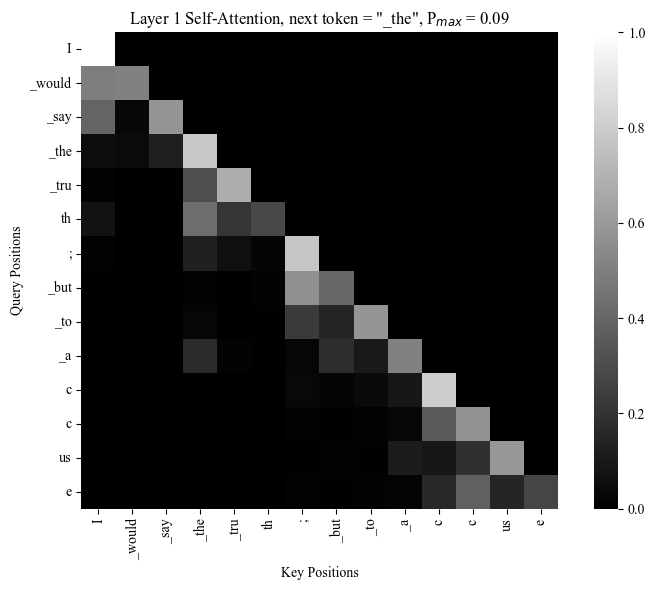

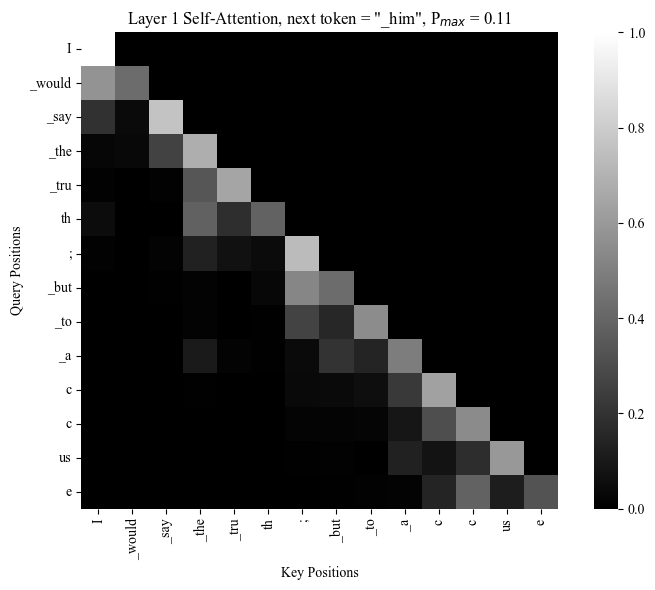

In [533]:
for t in [0, 9, 18]:
    plot_attention(slices[t], vocab, "I would say the truth; but to accuse",
                   idx = -1, layers = [0])

We can see from these graphs that, the attention at first was chaotic (epoch = 1), no specific patterns were shown. However, as we trained it for longer time (epoch = 10), patterns show up, such as attention focuses on semantically holistic token combinations (e.g. the attention for the whole word "accuse" were high amongst pairs of its sublevel tokens, or "the" is with high attention on the following "truth" = "tru" + "th"). As we train it further (epoch = 19), some pairs of attention are enhanced and some are diminished, for example, "I" has lower attention on "the".

*What role do positional encodings play - could the model function without them?*

No. Although we have causal masks, the positional encodings plays an important role in guaranteeing the model is not positional or permutation invariant: "You can jump like rabbits" is totally different from "Can rabbits jump like you" semantically. Causal masks are not sufficient to enable the model to catch structural information encoded in positions.

*Reflect on runtime and memory footprint - where are the bottlenecks?*

1. The attention map seems to be activated mainly along the diagonal line -- could be reduced. As embed_dim (vocab_size) goes up, the computation could be of cost O(d_embed^2).
2. Matrix multiplication in Q, K, V also costs computationally O(d_model^2).
3. Attention recomputes a lot when the model is performing autoregressive generation. Each time only 1 token is selected and generated.

# AI Tool Usage Disclosure
**AI Tools Used**  ChatGPT (OpenAI, GPT-4 Configuration)

**AI Contribution**  The author asked ChatGPT to check whether the implementation is correct and how to improve it. ChatGPT also helped in writing only abstract and problem definition.

**Personal Contribution**  The author has written almost all of this code and the report (from Dataset description to the end). No AI assistant like Copilot was used in code writing. Some parts are inspired by the online documentation and forum posts about PyTorch and other package libraries. Some parameters are discussed with friends of the author.
